**Problem:** Build an ML system to verify the veracity of claims using PUBHEALTH dataset. PUBHEALTH is a comprehensive dataset for explainable automated fact-checking of public health claims. Each instance in the PUBHEALTH dataset has an associated
veracity label (true, false, unproven, mixture).

source: https://huggingface.co/datasets/health_fact

---


I approached this problem as a text classification problem. Therefore, I implemented a BERT-based text classification model.
There are a few challenges to overcome, such as imbalanced dataset, unguaranteed out-of-sample performance, and so on, which may need additional research to address.

Below is the steps taken to implement the fact-checker system:
1.   Load Data
2.   Process Data
3.   Develop the Model (BERT)
4.   Predict & Evaluate (63% Acc.)
5.   Data Augmentation + Predict & Evaluate (65% Acc.)
6.   Issues for consideration
7.   ANNEX - Data visualization



In [7]:
from google.colab import drive
drive.mount("/content/gdrive")

import os 
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/4_job/fact-checker')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [116]:
#install and import libraries
from IPython.display import clear_output
!pip install transformers datasets sentence_transformers umap-learn
clear_output(wait=False)

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

import sklearn
from transformers import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from src.bertClassifier import *

### 1. Load Data
Download the dataset (PUBHEALTH) and conduct a brief descriptive analysis of the data

In [118]:
from datasets import load_dataset
dataset = load_dataset("health_fact")

Using custom data configuration default
Reusing dataset health_fact (/root/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19)


  0%|          | 0/3 [00:00<?, ?it/s]

The downloaded dataset is in a dictionary format and divided into 'train', 'test', and 'validation' groups. Here, I merged and converted them into a dataframe format, which makes it easier to process and ingest into the model.

In [119]:
dataset.keys()

dict_keys(['train', 'test', 'validation'])

In [120]:
df_dataset = pd.concat([pd.DataFrame.from_dict(dataset['train'], orient='columns'),
                        pd.DataFrame.from_dict(dataset['test'], orient='columns'), 
                        pd.DataFrame.from_dict(dataset['validation'], orient='columns')])
len(df_dataset)

12292

### 2. Process Data

In [121]:
#NOTE: There are missing labels in the dataset which were replaced with -1.
#Here, I removed those data entries; there were 41 of them.

df_dataset = df_dataset[df_dataset.label != -1]
df_dataset = df_dataset.reset_index()
len(df_dataset)

12251

4 labels are identified as below:
*   0: False
*   1: Mixture
*   2: True
*   3: Unproven

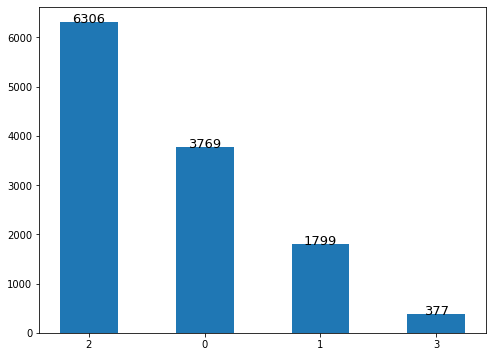

In [132]:
import matplotlib.pyplot as plt
# function to add value labels
def addlabels(x,y):
  for i, l in enumerate(x):
    plt.text(i, y[int(l)], y[int(l)], ha = 'center', fontsize=13)

fig, ax = plt.subplots(figsize = (8,6))
labs = [str(i) for i in df_dataset.label.value_counts().index]
cnt = df_dataset.label.value_counts()

ax.bar(labs, cnt, width=0.5)
# calling the function to add value labels
addlabels(labs, cnt)
plt.show()

In [133]:
#Split the dataset into train and test data in the ratio of 7:3
x_train,x_test,y_train,y_test=train_test_split(df_dataset.claim, df_dataset.label, test_size=0.3, random_state=8)

As shown below the max length of training data is 85 chars. So the MAX_LEN of BERT input size is configured as 85.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'response lengths')

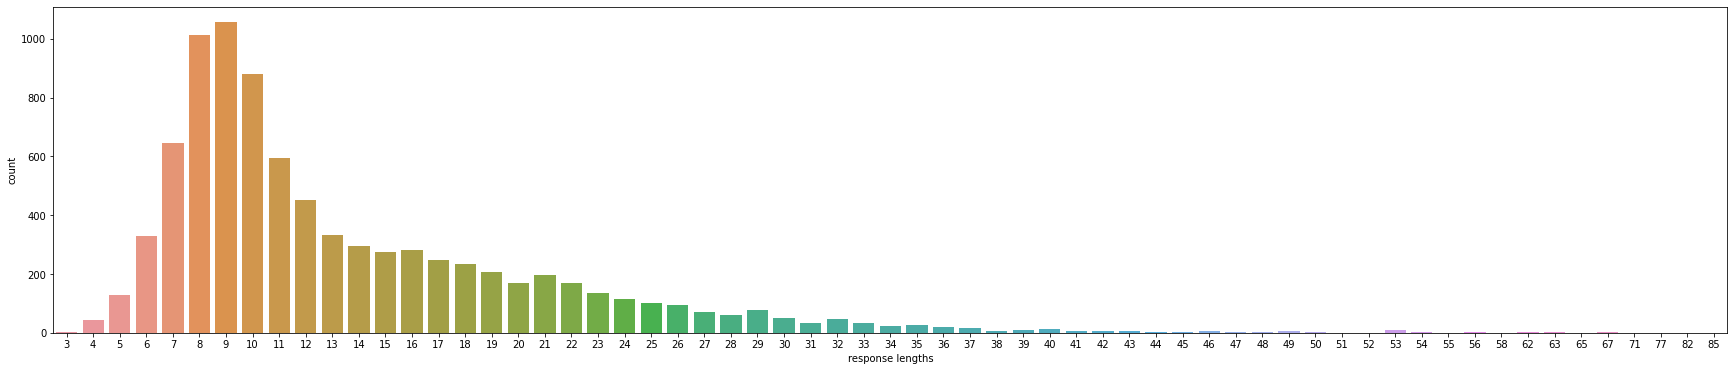

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
#from matplotlib import rc
from pylab import rcParams

rcParams['figure.figsize'] = 30, 6
ax = sns.countplot(x_train.str.split().str.len())
plt.xlabel('response lengths')
#ax.set_xticklabels(class_names);


## 3. Develop the Model (BERT)
Here, I only used the data from 'claim' column to train the model. The data is splitted into train and test data in the ratio of 7:3.

In [135]:
#### TRAINNIG PARAMETERS ####
# paparameters for the earlystop to prevent overfitting.
# PATIENCE: stop if no improvment for 5 epochs
# MIN_DELTA: the threshold that triggers the termination (acc should at least improve 0.0001)

BATCH_SIZE = 64
NUM_EPOCHS = 20
MAX_LEN=85
PATIENCE = 5
MIN_DELTA = 0.0001

#### 3.1. Tokenize training data
Before traing the BERT model, the input data must be tokenized into the format as required by BERT.

In [136]:
input_ids =[]
attention_masks =[]
token_type_ids =[]
train_data_labels = []

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')#,  cache_dir='bert_ckpt', do_lower_case=False)

for train_sent, train_label in zip(x_train, y_train):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(tokenizer, train_sent, MAX_LEN=MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        #########################################
        train_data_labels.append(train_label)
        
    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_input_ids=np.array(input_ids, dtype=int)
train_attention_masks=np.array(attention_masks, dtype=int)
train_token_type_ids=np.array(token_type_ids, dtype=int)
###########################################################
train_inputs=(train_input_ids, train_attention_masks, train_token_type_ids)
train_labels=np.asarray(train_data_labels, dtype=np.int32)

print("== A quick look at the tokenized inputs ==")
print(train_input_ids[0])
print(train_attention_masks[0])
print(train_token_type_ids[0])
print(tokenizer.decode(train_input_ids[0]))

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7

== A quick look at the tokenized inputs ==
[  101  6090 16748 10450  7315  1010 14671 11463 15909  2271  1006  2828
  1016  1007  1010  9617 21281  2721  9048  2015  1010 27641  1010  4372
  3401 21890 15909  2483  1010  2004 23606  2594  2273  2075 13706  1010
 18583  1010 12419  2791  1010  2128  7629 13706  1998  4958 28173  5149
 22930  2483  2024  2036  3205  2004  2217  3896  1012   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[CLS] pancreatitis, diabetes mellitus ( type 2 ), anaphylaxis, arthritis, encephalitis, as

#### 3.2. Train the Model

PARAMETER:
*   BATCH_SIZE = 64
*   NUM_EPOCHS = 20
*   PATIENCE = 5
*   MIN_DELTA = 0.0001

In [137]:
#initialize model. will use pretrained 'bert-base-uncased' as a base.
cls_model = TFBertClassifier(model_name='bert-base-uncased',
                             dir_path='bert_ckpt',
                             num_class=4)

#train and evaluate the model
cls_model, history = train_model(cls_model, train_inputs, train_labels, NUM_EPOCHS, BATCH_SIZE, PATIENCE, MIN_DELTA)

https://huggingface.co/bert-base-uncased/resolve/main/config.json not found in cache or force_download set to True, downloading to /content/gdrive/MyDrive/Colab Notebooks/4_job/fact-checker/bert_ckpt/tmpwdhtwdc7


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/config.json in cache at bert_ckpt/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
creating metadata file for bert_ckpt/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at bert_ckpt/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embed

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-uncased/resolve/main/tf_model.h5 in cache at bert_ckpt/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5
creating metadata file for bert_ckpt/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5
loading weights file https://huggingface.co/bert-base-uncased/resolve/main/tf_model.h5 from cache at bert_ckpt/775efbdc2152093295bc5824dee96da82a5f3c1f218dfface1b8cef3094bdf8f.c719a806caef7d36ec0185f14b3b5fa727d919f924abe35622b4b7147bfbb8c7.h5
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining mode

tf_bert_classifier -- Folder already exists 

Epoch 1/20
114/114 [==============================] - ETA: 0s - loss: 0.8815 - accuracy: 0.6136
Epoch 1: val_accuracy improved from -inf to 0.65734, saving model to tf_bert_classifier/weights.h5
114/114 [==============================] - 95s 704ms/step - loss: 0.8815 - accuracy: 0.6136 - val_loss: 0.7828 - val_accuracy: 0.6573
Epoch 2/20
114/114 [==============================] - ETA: 0s - loss: 0.7462 - accuracy: 0.6671
Epoch 2: val_accuracy did not improve from 0.65734
114/114 [==============================] - 76s 665ms/step - loss: 0.7462 - accuracy: 0.6671 - val_loss: 0.7956 - val_accuracy: 0.6239
Epoch 3/20
114/114 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.7175
Epoch 3: val_accuracy did not improve from 0.65734
114/114 [==============================] - 76s 664ms/step - loss: 0.6442 - accuracy: 0.7175 - val_loss: 0.8000 - val_accuracy: 0.6457
Epoch 4/20
114/114 [==============================] - ETA: 0s -

#### 3.3. Tokenize test data

In [138]:
input_ids =[]
attention_masks =[]
token_type_ids =[]
train_data_labels = []

for test_sent in x_test:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(tokenizer, test_sent, MAX_LEN=MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        #########################################
       
    except Exception as e:
        print(e)
        print(test_sent)
        pass
    
test_input_ids=np.array(input_ids, dtype=int)
test_attention_masks=np.array(attention_masks, dtype=int)
test_token_type_ids=np.array(token_type_ids, dtype=int)
###########################################################
test_inputs=(test_input_ids, test_attention_masks, test_token_type_ids)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## 4. Predict and Evaluate
As expected, the accuracies are very low for class 1 and 3 due to the data imbalance (under-representation).

In [139]:
results = cls_model.predict(test_inputs)
results = tf.argmax(results, axis=1)
print(classification_report(y_test, results))

              precision    recall  f1-score   support

           0       0.55      0.61      0.58      1110
           1       0.29      0.27      0.28       534
           2       0.81      0.76      0.78      1924
           3       0.26      0.36      0.30       108

    accuracy                           0.63      3676
   macro avg       0.48      0.50      0.49      3676
weighted avg       0.64      0.63      0.63      3676



## 5. Data Augmentation + Predict & Evaluate
To balance off the data imbalance, I tried the over-sampling of class 1 and 3 by generating similar sentences using a text generation model. Here, I used a pretrained model 'tuner007/pegasus_paraphrase' from Huggingface.

In [112]:
import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
model_name = 'tuner007/pegasus_paraphrase'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)#.to(torch_device)

def get_response(input_text,num_return_sequences,num_beams):
  batch = tokenizer([input_text],truncation=True,padding='longest',max_length=60, return_tensors="pt")#.to(torch_device)
  translated = model.generate(**batch,max_length=60,num_beams=num_beams, num_return_sequences=num_return_sequences, temperature=2)
  tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
  return tgt_text

clear_output(wait=False)

#### 5.1. Sentence Generation
Generating sentences for class 1 and 3. Over-sampling to around 2000 entries respectively. This may take some time.

Or skip this process to load from the saved pickle file.

In [ ]:
num_beams = 10
over_sample_num = 1000

#generate class 3 sentences.
da_list = []
num_return_sequences = 4#np.round(over_sample_num /len(df_dataset[df_dataset.label==3]['claim']))
for sen in df_dataset[df_dataset.label==3]['claim']:
  da_list.extend(get_response(sen,int(num_return_sequences),num_beams))
df_da_3 = pd.DataFrame(da_list, columns=['claim'])
df_da_3['label'] = 3

#generate class 1 sentences
da_list = []
num_return_sequences = 1#np.round(over_sample_num /len(df_dataset[df_dataset.label==1]['claim']))
for sen in df_dataset[df_dataset.label==1]['claim']:
  da_list.extend(get_response(sen,int(num_return_sequences),num_beams))
df_da_1 = pd.DataFrame(da_list, columns=['claim'])
df_da_1['label'] = 1

#combine generated sentences into df_da
df_da = pd.concat([df_da_3,df_da_1])

In [23]:
#save or load generated sentences
import pickle

# with open('data/aug_df_da_3.pickle', 'wb') as fp:
#   pickle.dump(df_da_3, fp)

with open('data/aug_df_data.pickle', 'rb') as fp:
  docs_df = pd.DataFrame(pickle.load(fp))

Some samples of generated sentences look like.

In [24]:
for sen in docs_df[:5].claim:
  print(sen)

John Kerry funneled taxpayer money into his daughter's charity.
Secretary of State John Kerry funneled taxpayer money into his daughter's charity.
"Secretary of State John Kerry funneled taxpayer money into his daughter's charity."
The Secretary of State funneled taxpayer money into his daughter's charity.
"Secretary of State John Kerry funneled taxpayer money into his daughter's global charity."


In [94]:
df_da_3 = docs_df[docs_df.label == 3]
df_da_1 = docs_df[docs_df.label == 1].sample(frac=0.3, replace=True, random_state=1)

In [95]:
df_da_com = pd.concat([df_da_3, df_da_1])
df_da_com

,claim,label
0,John Kerry funneled taxpayer money into his da...,3
1,Secretary of State John Kerry funneled taxpaye...,3
2,"""Secretary of State John Kerry funneled taxpay...",3
3,The Secretary of State funneled taxpayer money...,3
4,"""Secretary of State John Kerry funneled taxpay...",3
...,...,...
168,A man mourning the death of his daughter was a...,1
944,Chocolate reduces women's stroke risk.,1
1182,"The impact on minorities is basically on par, ...",1
1431,The rights of a rape or sexual assault victim ...,1


In [96]:
print(len(df_da_1), len(df_da_3))

540 1885


Size of addition:
* Label 3: 1885
* Label 1: 540

I didn't add too much as it could cause negative influences on other class performance.

Lets see how the data distribution is changed.

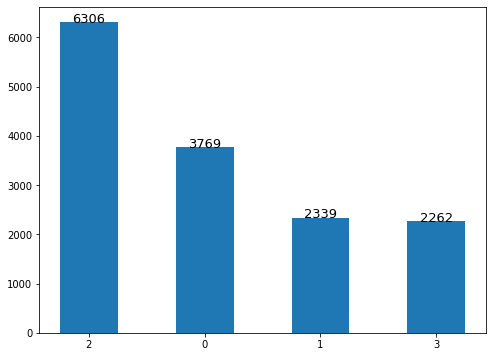

In [97]:
augmented_dataset = df_dataset[['claim','label']]
augmented_dataset = pd.concat([augmented_dataset, df_da_com])
augmented_dataset

import matplotlib.pyplot as plt
# function to add value labels
def addlabels(x,y):
  for i, l in enumerate(x):
    plt.text(i, y[int(l)], y[int(l)], ha = 'center', fontsize=13)

fig, ax = plt.subplots(figsize = (8,6))
labs = [str(i) for i in augmented_dataset.label.value_counts().index]
cnt = augmented_dataset.label.value_counts()

ax.bar(labs, cnt, width=0.5)
# calling the function to add value labels
addlabels(labs, cnt)
plt.show()

Split dataset & merge generated sentences with train data

In [98]:
#Split the dataset
x_train,x_test,y_train,y_test=train_test_split(df_dataset.claim, df_dataset.label, test_size=0.3, random_state=8)

#include augumented data in the train data
comb = pd.concat([pd.concat([x_train,df_da_com.claim]),pd.concat([y_train,df_da_com.label])],axis=1)
comb = comb.sample(frac=1).reset_index(drop=True)
x_train = comb.claim
y_train = comb.label

In [99]:
from transformers import *

tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')#,  cache_dir='bert_ckpt', do_lower_case=False)

input_ids =[]
attention_masks =[]
token_type_ids =[]
train_data_labels = []

for train_sent, train_label in zip(x_train, y_train):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(tokenizer, train_sent, MAX_LEN=MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        #########################################
        train_data_labels.append(train_label)
        
    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_input_ids=np.array(input_ids, dtype=int)
train_attention_masks=np.array(attention_masks, dtype=int)
train_token_type_ids=np.array(token_type_ids, dtype=int)
###########################################################
train_inputs=(train_input_ids, train_attention_masks, train_token_type_ids)
train_labels=np.asarray(train_data_labels, dtype=np.int32)

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7

In [100]:
print(train_input_ids[0])
print(train_attention_masks[0])
print(train_token_type_ids[0])
print(tokenizer.decode(train_input_ids[0]))

[  101  2128  7583  3111  1024  6861  2005 21454   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
[CLS] remedies : honey for coughing [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [101]:
#initialize model. will use pretrained 'bert-base-uncased' as a base.
#emilyalsentzer/Bio_ClinicalBERT
#bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16
cls_model = TFBertClassifier(model_name='bert-base-uncased',
                                  dir_path='bert_ckpt',
                                  num_class=4)

#train and evaluate the model
cls_model, history = train_model(cls_model, train_inputs, train_labels, NUM_EPOCHS, BATCH_SIZE, PATIENCE, MIN_DELTA)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at bert_ckpt/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/tf_model.h5 from cache at bert_ckpt/775efbdc2152093295bc5

tf_bert_classifier -- Folder already exists 

Epoch 1/20
147/147 [==============================] - ETA: 0s - loss: 0.9395 - accuracy: 0.5852
Epoch 1: val_accuracy improved from -inf to 0.65273, saving model to tf_bert_classifier/weights.h5
147/147 [==============================] - 120s 712ms/step - loss: 0.9395 - accuracy: 0.5852 - val_loss: 0.7880 - val_accuracy: 0.6527
Epoch 2/20
147/147 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.6999
Epoch 2: val_accuracy improved from 0.65273 to 0.69212, saving model to tf_bert_classifier/weights.h5
147/147 [==============================] - 102s 694ms/step - loss: 0.6833 - accuracy: 0.6999 - val_loss: 0.6548 - val_accuracy: 0.6921
Epoch 3/20
147/147 [==============================] - ETA: 0s - loss: 0.5111 - accuracy: 0.7848
Epoch 3: val_accuracy improved from 0.69212 to 0.70121, saving model to tf_bert_classifier/weights.h5
147/147 [==============================] - 103s 701ms/step - loss: 0.5111 - accuracy: 0.7848 

In [102]:
input_ids =[]
attention_masks =[]
token_type_ids =[]
train_data_labels = []

for test_sent in x_test:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(tokenizer,test_sent, MAX_LEN=MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        #########################################
       
    except Exception as e:
        print(e)
        print(test_sent)
        pass
    
test_input_ids=np.array(input_ids, dtype=int)
test_attention_masks=np.array(attention_masks, dtype=int)
test_token_type_ids=np.array(token_type_ids, dtype=int)
###########################################################
test_inputs=(test_input_ids, test_attention_masks, test_token_type_ids)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [103]:
from sklearn.metrics import confusion_matrix, classification_report
results = cls_model.predict(test_inputs)
results = tf.argmax(results, axis=1)
print(classification_report(y_test, results))

              precision    recall  f1-score   support

           0       0.54      0.69      0.60      1110
           1       0.34      0.29      0.32       534
           2       0.87      0.72      0.79      1924
           3       0.43      0.81      0.56       108

    accuracy                           0.65      3676
   macro avg       0.55      0.63      0.57      3676
weighted avg       0.68      0.65      0.66      3676



## 6. Issues for consideration:

* **Data imbalance:** Class 1 (mixture) and 3 (unproven) are strongly under-represented. Need to explore whether data augmentation can contribute to improving the accuracy. Based on a quick data augmentation test above, it seems class 1 and 3 are naturally hard to predict with the text classifier even with augmented data. Maybe need to try other augmentation approaches, e.g. SMOTE, etc.
* **Multi-point scale prediction:** Predicting the multi-point scale (true, false, mixture, unproven) with a text classifier seems particularly challenging with this case, especially when 'mixture' and 'unproven' require semantic-level reasoning, which makes the problem more challenging.
* **Literature review:** there are many papers discussing on this matter, one of suggested approaches is creating numeric embedding of claims to compare that with retrieved evidence. This can be an option to explore to address the challenges stated above.



### 7. ANNEX - Data Visualization

Visualization of sentence embeddings (claims)

BERT Embedding

In [ ]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

targets = df_dataset.claim.copy()

embeddings = []
sentence_model = SentenceTransformer('all-mpnet-base-v2')

for i in tqdm(range(len(targets))):
  embedding = sentence_model.encode(targets[i])
  emb = torch.stack([torch.Tensor(embedding)])
  embeddings.append(emb)
embeddings = torch.cat(embeddings, dim=0)

In [91]:
embeddings

tensor([[ 0.0209,  0.1842,  0.0480,  ..., -0.0247,  0.0097,  0.0283],
        [-0.0235,  0.0173, -0.0224,  ...,  0.0594,  0.0543,  0.0075],
        [-0.0034,  0.0079, -0.0226,  ..., -0.0110, -0.0673, -0.0172],
        ...,
        [ 0.0034,  0.0638,  0.0139,  ...,  0.0294, -0.0283, -0.0340],
        [ 0.0359, -0.0468,  0.0200,  ...,  0.0541, -0.0159, -0.0365],
        [-0.0101,  0.0418, -0.0209,  ...,  0.0047, -0.0572,  0.0126]])

In [97]:
from torch.nn import BatchNorm1d
from sklearn.manifold import TSNE
import torch
from sklearn.cluster import *
import umap

MAX_TOKENS = 20000
clustering_result = {"multilingual": {}, "char": {}}

targets = df_dataset.claim.copy()


target_vectors = embeddings

#Normalization
with torch.no_grad():
    target_vectors = BatchNorm1d(target_vectors.shape[1])(target_vectors)
    print("Normalizing finished")

#Standardization
# target_vectors = StandardScaler().fit_transform(target_vectors)
# print("Standardization completed")

## DIMENSION REDUCTION ##
#### TSNE #####
# tsne = TSNE(n_components=2, learning_rate=50.0, n_iter = 1000, perplexity=10)
# target_vectors = torch.tensor(tsne.fit_transform(target_vectors.detach().numpy()))
# print("T-SNE finished")
  
target_vectors = torch.tensor(
    umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.01, metric='cosine').fit_transform(target_vectors))
print("UMAP finished")



Normalizing finished
T-SNE finished


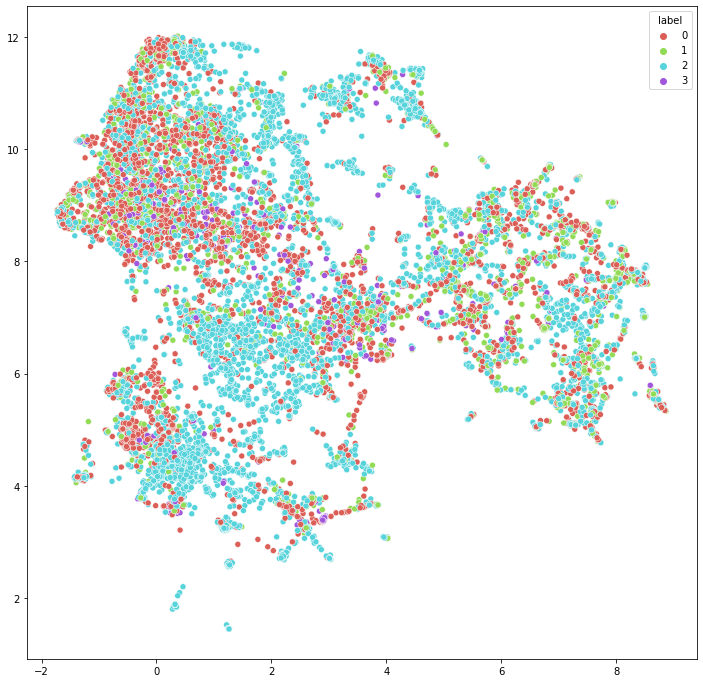

In [98]:
plt.figure(figsize=(12, 12)) 
sns.scatterplot(x = target_vectors[:,0], y = target_vectors[:,1], hue = df_dataset.label, palette = sns.hls_palette(4), legend = 'full');